# Comparing different lexicons

Let's see how sentiment analysis results will change when we change the lexicon we use for finding out emotional words.

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm

In [2]:
import warnings
warnings.simplefilter("ignore")

Also, some imports with Jupyter Notebook magic:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

...and some fixed variables:

In [4]:
from pymystem3 import Mystem
mystem = Mystem()

## 1 &emsp; Data preparation

### 1.1 &emsp; Lexicons

Loading lexicon list:

In [5]:
path_to_lexicons = "./data/sentiment_datasets"
lexicons = [lex[:-4] for lex in os.listdir(path_to_lexicons) if lex.endswith(".csv")]

List of lexicons we are going to use are:

In [6]:
lexicons

['RuSentiLex', 'EmoLex', 'LinisCrowd', 'ChenSkiena', 'ProductSentiRus']

Now, loading the lexicons themselves:

In [7]:
lexicons_dict = {}
for lexicon in lexicons:
    lex_df = pd.read_csv("./data/sentiment_datasets/{}.csv".format(lexicon), sep=";", encoding="utf-8")
    lexicons_dict[lexicon] = lex_df

### 1.2 &emsp; Plays

Plays we'll be analysing in this case:

In [8]:
with open("./data/rusdracor_list.txt", "r", encoding="utf-8") as f:
    play_list = [play.strip("\n") for play in f.readlines()]

Plays:

In [9]:
print(", ".join(play_list))

andreyev-ne-ubiy, andreyev-mysl, andreyev-k-zvezdam, afinogenov-mashenka, babel-marija, babel-zakat, belsky-skazanie-o-nevidimom-grade-kitezhe, blok-balaganchik, blok-neznakomka, blok-korol-na-ploschadi, bulgakov-ivan-vasilevich, bulgakov-beg, bulgakov-zojkina-kvartira, bulgakov-poslednie-dni, bulgakov-poloumnyj-zhurden, bulgakov-dni-turbinyh, bulgakov-kabala-svjatosh, bulgakov-vojna-i-mir, bulgakov-batum, bulgakov-adam-i-eva, glinka-velzen, gogol-igroki, gogol-utro-delovogo-cheloveka, gogol-teatralnyi-razezd, gogol-tjazhba, gogol-otryvok, gogol-zhenitba, gogol-revizor, gogol-lakeiskaja, gorky-egor-bulychov-i-drugie, gorky-na-dne, gorky-vassa-zheleznova, griboyedov-molodye-suprugi, griboyedov-gore-ot-uma, gumilyov-akteon, gumilyov-ditja-allaha, gumilyov-gondla, gumilyov-don-zhuan-v-egipte, dashkova-toisiokov, ekaterina-vtoraja-o-vremja, ekaterina-vtoraja-iz-zhizni-rjurika, ekaterina-vtoraja-rasstroennaja-semja, zagoskin-blagorodnyj-teatr, kapnist-antigona, kapnist-yabeda, kedrin-rembra

### 1.3 &emsp; Storing information

This dictionary will later be a dataframe to collect all the information and visualise it later.

In [10]:
overall_dict = {
    "play": [],
    "lexicon": [],
    "spoken, total": [],
    "spoken positive": [],
    "spoken positive, %": [],
    "spoken negative": [],
    "spoken negative, %": [],
    "stage, total": [],
    "stage positive": [],
    "stage positive, %": [],
    "stage negative": [],
    "stage negative, %": []
}

## 2 &emsp; Extracting emotional phrases

In any given phrase, each token will be lemmatized and checked against the lexicon. If the lemma is there, token's polarity is added to phrase polarity (+1 for positive, -1 for negative). The polarity of overall sum (either positive or negative) will be the final result.

In [11]:
# this is a one-liner to get the sign of a given integer to use later
# also capable of returning 0 when given 0
sign = lambda x: x and (1, -1)[x < 0]
# thx stackoverflow! <3

In [12]:
def evaluate_phrase_polarity(phrase, lexicon):
    """Calculates polarity for the whole phrase.
    
    :arg phrase (str) - phrase to evaluate
    :arg lexicon (pandas.DataFrame) - lexicon to check the lemmas
    
    :returns phrase_sum (int)
    """
    phrase_sum = 0
    lemmas = [parse["analysis"][0]["lex"] for parse in mystem.analyze(phrase) if parse.get("analysis")]
    for lemma in lemmas:
        if lemma in lexicon["lemma"].values:
            lemma_polarity = lexicon[lexicon["lemma"] == lemma].iloc[0]["sentiment"]
            phrase_sum += lemma_polarity
    return sign(phrase_sum)

In [13]:
def analyse_type(phrases, lexicon):
    """Pipeline for sentiment analysis of all phrases of a given type in a play.
    
    :arg phrases (list of str) - drama lines
    :arg lexicon (pandas.DataFrame) - lexicon to check the lemmas
    
    :returns type_total (int) - line count
    :returns type_positive (int) - count of positively evaluated lines
    :returns type_negative (int) - count of negatively evaluated lines
    """
    type_total = len(phrases)
    type_positive = 0
    type_negative = 0
    for phrase in phrases:
        sent = evaluate_phrase_polarity(phrase, lexicon)
        if sent > 0:
            type_positive += 1
        elif sent < 0:
            type_negative += 1
    return type_total, type_positive, type_negative

## 3 &emsp; Running the experiment

### 3.1 &emsp; Workflow for a single play

In [14]:
def analyse_play(play_name, lexicon_name, lexicon):
    # load drama lines
    with open("./data/rusdracor/spoken_lemmas/{}.txt".format(play_name), "r", encoding="utf-8") as spoken_src:
        play_spoken = [l.strip("\n") for l in spoken_src.readlines() if l != "\n"]
    with open("./data/rusdracor/stage_lemmas/{}.txt".format(play_name), "r", encoding="utf-8") as stage_src:
        play_stage = [l.strip("\n") for l in stage_src.readlines() if l != "\n"]
    # analyse lines
    spoken_total, spoken_positive, spoken_negative = analyse_type(play_spoken, lexicon)
    stage_total, stage_positive, stage_negative = analyse_type(play_stage, lexicon)
    # save information
    overall_dict["play"].append(play_name)
    overall_dict["lexicon"].append(lexicon_name)
    overall_dict["spoken, total"].append(spoken_total)
    overall_dict["spoken positive"].append(spoken_positive)
    overall_dict["spoken positive, %"].append(spoken_positive/spoken_total*100)
    overall_dict["spoken negative"].append(spoken_negative)
    overall_dict["spoken negative, %"].append(spoken_negative/spoken_total*100)
    overall_dict["stage, total"].append(stage_total)
    overall_dict["stage positive"].append(stage_positive)
    overall_dict["stage positive, %"].append(stage_positive/stage_total*100)
    overall_dict["stage negative"].append(stage_negative)
    overall_dict["stage negative, %"].append(stage_negative/stage_total*100)

`tqdm` will visualise the progress.

In [26]:
# uncomment this to run the whole thing again
# for play_name in tqdm(play_list):
#     for lexicon_name in lexicons:
#         lexicon_df = lexicons_dict[lexicon_name]
#         analyse_play(play_name, lexicon_name, lexicon_df)

100%|██████████| 210/210 [1:28:20<00:00, 25.24s/it]


![](https://i.ytimg.com/vi/YINJj6DzBps/maxresdefault.jpg)

## 4 &emsp; Converting information to pandas dataframe

In [15]:
# df = pd.DataFrame.from_dict(overall_dict)
df = pd.read_csv("./data/lexicons_experiment.csv", sep=";", encoding="utf-8")
df.head()

,play,lexicon,"spoken, total",spoken positive,"spoken positive, %",spoken negative,"spoken negative, %","stage, total",stage positive,"stage positive, %",stage negative,"stage negative, %"
0,andreyev-ne-ubiy,RuSentiLex,971,155,15.962925,287,29.557158,340,37,10.882353,67,19.705882
1,andreyev-ne-ubiy,EmoLex,971,335,34.500515,144,14.830072,340,57,16.764706,54,15.882353
2,andreyev-ne-ubiy,LinisCrowd,971,140,14.418126,284,29.248198,340,36,10.588235,61,17.941176
3,andreyev-ne-ubiy,ChenSkiena,971,420,43.254377,131,13.491246,340,73,21.470588,49,14.411765
4,andreyev-ne-ubiy,ProductSentiRus,971,10,1.029866,684,70.442842,340,2,0.588235,221,65.000000


In [37]:
# df.to_csv("./data/lexicons_experiment.csv", sep=";", encoding="utf-8", index=False)

## 5 &emsp; Visualisation

Let's visualise amounts of found emotional lines by play for each lexicon:

### 5.1 &emsp; Spoken text

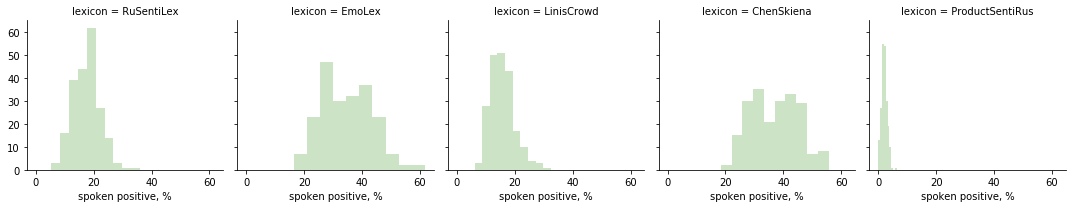

In [67]:
g = sns.FacetGrid(df, col="lexicon")
sns.set_palette(sns.cubehelix_palette(7, start=.8))
# plt.suptitle("Distribution of positive phrases in plays")
g.map(plt.hist, "spoken positive, %");
plt.savefig("./data/figures/spoken_positive_by_lexicon.png", dpi=600)

X-axis is a percentage of phrases in a play labeled positive, Y-axis is amount of plays with given percentage.

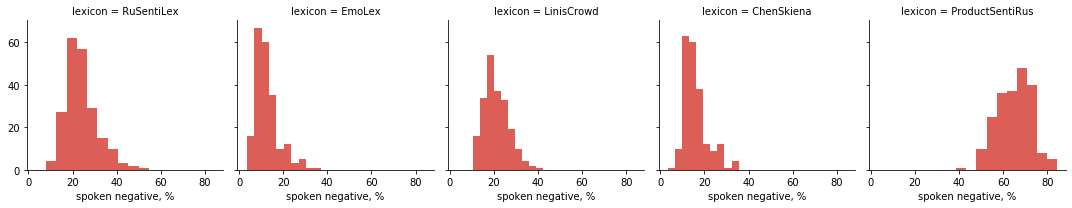

In [69]:
g = sns.FacetGrid(df, col="lexicon")
sns.set_palette(sns.color_palette("hls", 8))
g.map(plt.hist, "spoken negative, %");
plt.savefig("./data/figures/spoken_negative_by_lexicon.png", dpi=600)

### 5.2 &emsp; Stage directions

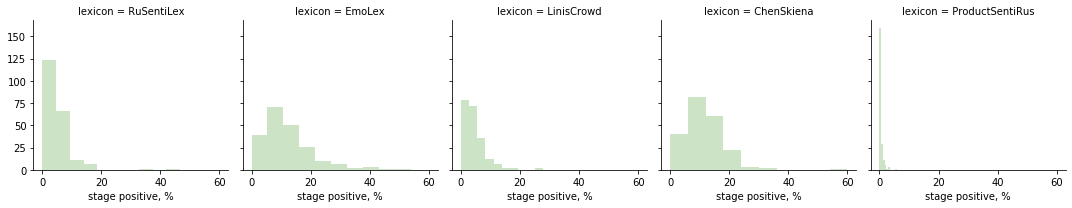

In [71]:
g = sns.FacetGrid(df, col="lexicon")
sns.set_palette(sns.cubehelix_palette(7, start=.8))
# plt.suptitle("Distribution of positive phrases in plays")
g.map(plt.hist, "stage positive, %");
plt.savefig("./data/figures/stage_positive_by_lexicon.png", dpi=600)

X-axis is a percentage of phrases in a play labeled positive, Y-axis is amount of plays with given percentage.

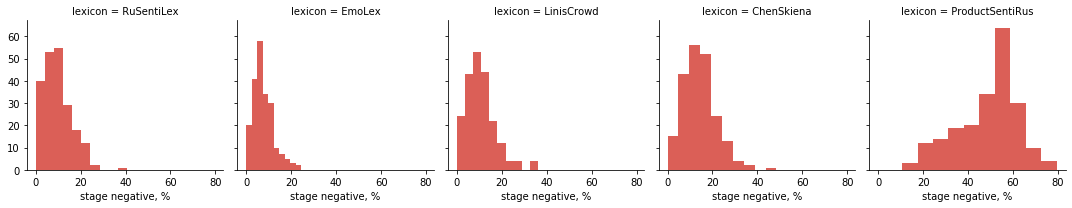

In [73]:
g = sns.FacetGrid(df, col="lexicon")
sns.set_palette(sns.color_palette("hls", 8))
g.map(plt.hist, "stage negative, %");
plt.savefig("./data/figures/stage_negative_by_lexicon.png", dpi=600)

### 5.3 &emsp; What can we get from these?

- stage directions are, in general, less emotional (as expected)

- results shown by EmoLex and Chen and Skiena's lexicons are quite the same, especially when looking at spoken text (this might be due to the fact that they are both Google Translate-based)

- ProductSentiRus shows way too much negative stage directions (needs a more proper check)